In [28]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
import matplotlib.pyplot as plt

from skactiveml.pool import UncertaintySampling, GreedySamplingX, GreedySamplingTarget, QueryByCommittee

from skactiveml.regressor import SklearnRegressor

Sources for activeml:
https://scikit-activeml.github.io/latest/generated/tutorials/02_pool_regression_getting_started.html
https://www.preprints.org/frontend/manuscript/799d8399c7124b39f21cfd2cd49dccaf/download_pub

In [29]:
# Default parameters for matplotlib plots
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.facecolor'] = (0.9,0.9,0.9)
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'w'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['legend.fontsize'] = 22
mpl.rcParams['legend.facecolor'] = [1,1,1]
mpl.rcParams['legend.framealpha'] = 0.75
mpl.rcParams['axes.labelsize'] = 22

In [30]:
# helper function for plotting the results
def plot():
    # data for plotting
    X_plot = np.linspace(0, 20, 1000)[:, None]
    y_GP, y_std = regressor.predict(X_plot, return_std=True)
    y_GP = y_GP.reshape(-1)

    plt.scatter(X, y_true, c="k", label="data")
    plt.plot(X_plot, y_GP, color="navy", lw=1, label="GPR")
    plt.fill_between(X_plot[:, 0], y_GP - y_std, y_GP + y_std, color="blue", alpha=0.2)
    plt.title("Initial estimation based on %i points"%n_initial)
    plt.legend(loc="best", scatterpoints=1, prop={"size": 12})

In [31]:
# Adapted from: https://www.preprints.org/manuscript/202507.0252/v1

# generate noisy sin(x) data
random_state = np.random.RandomState(0)
X = random_state.choice(np.linspace(0, 20, 10000), size=200, replace=False).reshape(-1, 1)
y_true =  (np.sin(X) + np.random.normal(scale=0.3, size=X.shape)).ravel()


In [32]:
kernel = RBF(length_scale = 1.0, length_scale_bounds=(1e-4, 1e4)) \
         + WhiteKernel(noise_level = 1, noise_level_bounds = (1e-10, 1e+1))

gp = GaussianProcessRegressor(random_state=0, kernel = kernel)

regressor = SklearnRegressor( gp, random_state=0, missing_label=np.nan)

qs =  GreedySamplingTarget(method="GSi", random_state=0)

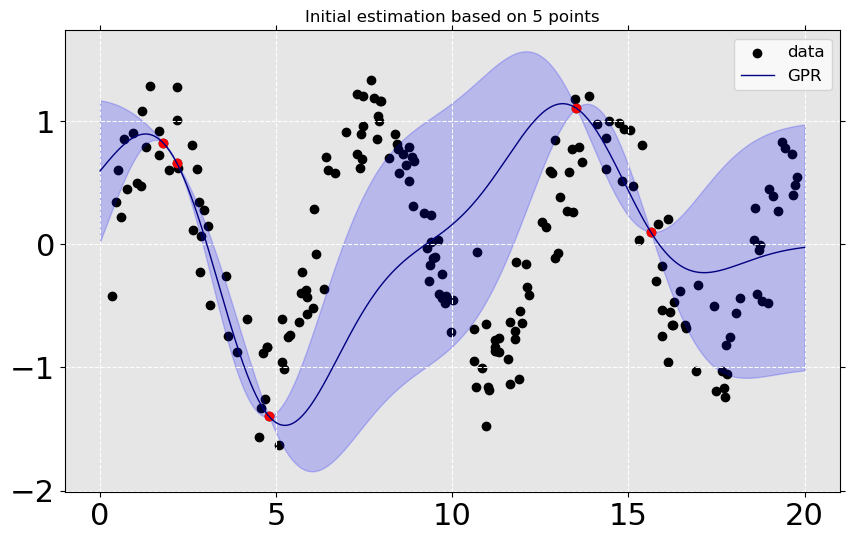

In [33]:
n_initial = 5
initial_idx = np.random.choice(range(len(X)), size = n_initial, replace = False)
y_training = np.full_like(y_true, fill_value=np.nan)
y_training[initial_idx] = y_true[initial_idx]

regressor.fit(X, y_training)

plot()
l=plt.scatter(X, y_training, c="red")

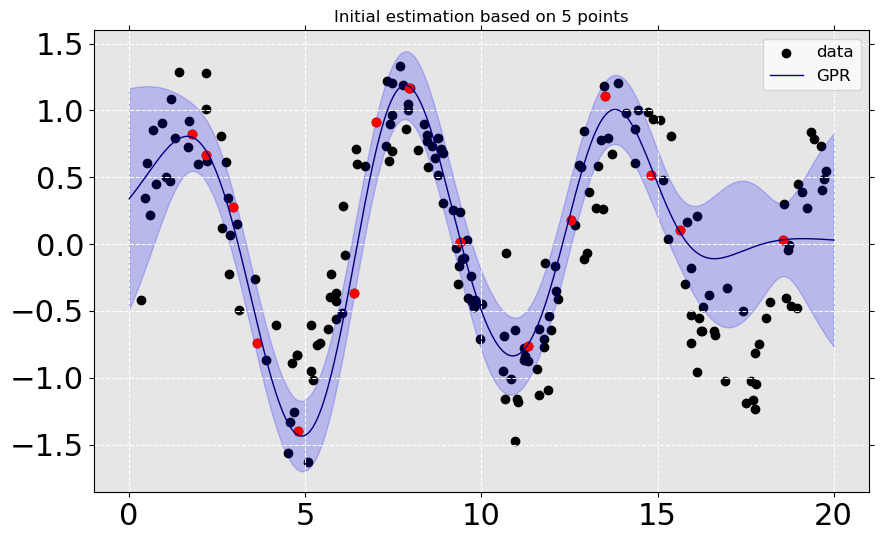

In [34]:
# active learning
n_cycles = 10
for c in range(n_cycles):
    regressor.fit(X, y_training)
    q_ids, u_scores = qs.query(X=X, y=y_training, reg=regressor, fit_reg=False, batch_size=1, return_utilities=True)
    # update y_training
    y_training[q_ids] = y_true[q_ids]

# Fit final regressor.
regressor.fit(X, y_training)


plot()
l=plt.scatter(X, y_training, c="red")

In [ ]:
# --->>> Your turn <<<---
# Try to apply active learning to the penguins dataset and/or the iris flower dataset
#
# See https://scikit-activeml.github.io/latest/generated/tutorials/00_pool_getting_started.html
